In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch

# Directories for real and fake videos
real_videos_dir = '/kaggle/input/reduced-celebdf/Reduced_CelebDF/real_videos'
fake_videos_dir = '/kaggle/input/reduced-celebdf/Reduced_CelebDF/fake_videos'

# Frame extraction function
def extract_frames(video_path, label, frames_dir):
    cap = cv2.VideoCapture(video_path)
    count = 0
    extracted_frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Save frame every nth frame (to reduce processing load)
        if count % 10 == 0:  # Change 10 to adjust frequency
            frame_path = os.path.join(frames_dir, f"{os.path.basename(video_path)}_frame{count}.jpg")
            cv2.imwrite(frame_path, frame)
            extracted_frames.append((frame_path, label))
        count += 1
    cap.release()
    return extracted_frames

# Prepare dataset
def prepare_dataset(real_videos_dir, fake_videos_dir, frames_dir):
    os.makedirs(frames_dir, exist_ok=True)
    dataset = []
    # Extract frames from real videos
    for video in os.listdir(real_videos_dir):
        video_path = os.path.join(real_videos_dir, video)
        dataset.extend(extract_frames(video_path, label=0, frames_dir=frames_dir))  # 0 for real
    # Extract frames from fake videos
    for video in os.listdir(fake_videos_dir):
        video_path = os.path.join(fake_videos_dir, video)
        dataset.extend(extract_frames(video_path, label=1, frames_dir=frames_dir))  # 1 for fake
    return dataset

# Custom dataset class
class FrameDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        frame_path, label = self.data[idx]
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if self.transform:
            frame = self.transform(frame)
        return frame, torch.tensor(label, dtype=torch.long)

# Frame storage directory
frames_dir = '/kaggle/working/extracted_frames'

# Prepare the dataset
dataset = prepare_dataset(real_videos_dir, fake_videos_dir, frames_dir)

# Train-test split
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42, stratify=[label for _, label in dataset])

# Data transformations (optional)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Create PyTorch data loaders
train_loader = DataLoader(FrameDataset(train_data, transform=transform), batch_size=32, shuffle=True)
test_loader = DataLoader(FrameDataset(test_data, transform=transform), batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Total frames: {len(dataset)}")
print(f"Train frames: {len(train_data)}")
print(f"Test frames: {len(test_data)}")


Total frames: 2142
Train frames: 1713
Test frames: 429


In [2]:
pip install timm


Note: you may need to restart the kernel to use updated packages.


In [4]:
import timm
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the Vision Transformer model
class VisionTransformerModel(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(VisionTransformerModel, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)  # Replace the head for binary classification
    
    def forward(self, x):
        return self.vit(x)

# Initialize the model, loss, and optimizer
model = VisionTransformerModel(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformerModel(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate

Training Epoch 1/5: 100%|██████████| 54/54 [01:04<00:00,  1.19s/it]


Epoch [1/5], Loss: 0.6136, Accuracy: 75.60%


Training Epoch 2/5: 100%|██████████| 54/54 [01:08<00:00,  1.27s/it]


Epoch [2/5], Loss: 0.5472, Accuracy: 76.53%


Training Epoch 3/5: 100%|██████████| 54/54 [01:08<00:00,  1.26s/it]


Epoch [3/5], Loss: 0.5395, Accuracy: 77.88%


Training Epoch 4/5: 100%|██████████| 54/54 [01:08<00:00,  1.27s/it]


Epoch [4/5], Loss: 0.5402, Accuracy: 77.88%


Training Epoch 5/5: 100%|██████████| 54/54 [01:08<00:00,  1.27s/it]


Epoch [5/5], Loss: 0.5147, Accuracy: 78.87%
Model saved to /kaggle/working/vit_model.pth


Testing: 100%|██████████| 14/14 [00:07<00:00,  1.83it/s]



Classification Report:
              precision    recall  f1-score   support

        Real       1.00      0.17      0.29        95
        Fake       0.81      1.00      0.89       334

    accuracy                           0.82       429
   macro avg       0.90      0.58      0.59       429
weighted avg       0.85      0.82      0.76       429



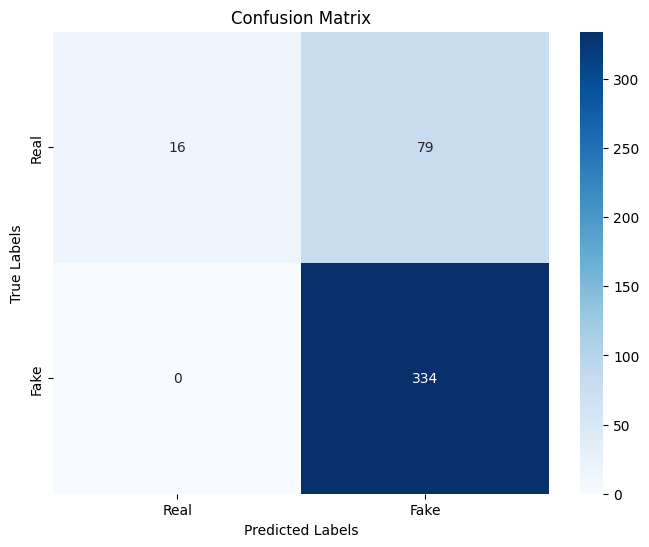

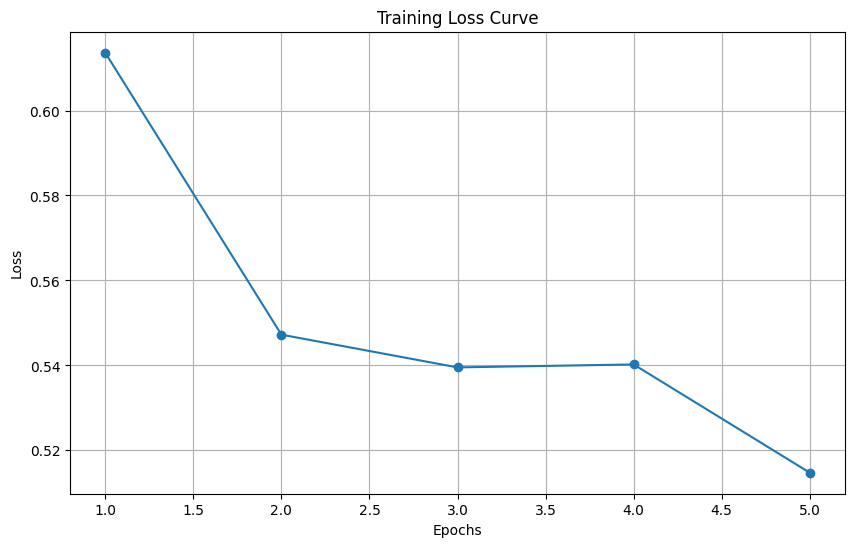

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

# Train function with loss tracking
def train_model(model, train_loader, optimizer, criterion, epochs=5, save_path='vit_model.pth'):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")
    
    # Save the model
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")
    return train_losses

# Test function with classification report
def test_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=['Real', 'Fake']))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title("Confusion Matrix")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()

# Plot loss curve
def plot_loss_curve(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-')
    plt.title("Training Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

# Train and test the model
save_path = '/kaggle/working/vit_model.pth'
train_losses = train_model(model, train_loader, optimizer, criterion, epochs=5, save_path=save_path)
test_model(model, test_loader)

# Plot loss curve
plot_loss_curve(train_losses)
